In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

In [2]:
metals = {'Li', 'Be', 'Na', 'Mg', 'Al', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi'}
non_metals = {'H', 'B', 'C', 'N', 'O', 'F', 'Si', 'P', 'S', 'Cl', 'As', 'Se', 'Br', 'Te', 'I', 'At'}

In [3]:
Umlip_dict = {
    "0": "0-GRACE-2L-OMAT",
    "1": "1-GRACE-2L-OAM",
    "2": "2-eqV2-31",
    "3": "3-eqV2-86",
    "4": "4-eqV2-153",
    "5": "5-DPA3-v1",
    "6": "6-DPA3-V2",
    "7": "7-7net",
    "8": "8-esen",
    "9": "9-MACE-omat",
    "10": "10-eqV2-31-omat",
    "11": "11-eqV2-86-omat",
    "12": "12-eqV2-153-omat",
    "13": "13-esen-omat",
    "14": "14-orb-omat-c-inf-conf",
    "15": "15-orb-omat-20",
    "16": "16-orb-omat-d-inf",
    "17": "17-orb-omat-d-20",
    "18": "18-7net-omat",
    "19": "19-7net-omat-2",
    "20": "20-MACE-mpa"
}

In [4]:
# Sort UMLIPs in ascending order by force RMSE
Use_umlip_all = [13,12,10,11,19,18,7,9,15,14,17,16,2,3,4,8,0,1,6,5] 
Force_RMSE = [0.23719, 0.2382, 0.243286, 0.24351, 0.253712, 0.2643,
              0.27751, 0.350226, 0.48766, 0.49757, 0.50635, 0.5111, 0.779,
              0.81703, 0.87125, 1.0775, 1.384136, 1.5914649, 2.46236, 6.22137]
# Energy_RMSE = [1.38414, 1.59146, 0.779, 0.81703, 0.87125, 
#                6.22137, 2.46236, 0.27751, 1.0775, 0.35023, 
#                0.243286, 0.24351, 0.2382, 0.23719, 
#                0.49757, 0.48766, 0.5111, 0.50635,0.2643, 0.25371]

reciprocal = 1 / np.array(Force_RMSE)
force_weight_all = reciprocal / np.sum(reciprocal)

In [15]:
RMSE_force = []
Result = {}
rho_list = []
for TopN in range(5,15):
    Use_umlip = Use_umlip_all[:TopN]
    force_weight = force_weight_all[:TopN]
    Conf_Info_All = []
    Force_RMSE_umlip = []
    for i in range(1, 4):
        df_dft = pd.read_pickle(f"./DFT/OMAT24-test-part{i}.pckl.gzip", compression="gzip")
        Nstru_all = df_dft.shape[0]
        df_dft["energy_peratom"] = df_dft.apply(lambda row: row["energy"] / 
                                                row["ase_atoms"].get_global_number_of_atoms(), axis=1)
        df_dft = df_dft.reset_index(drop=True)

        for n in Use_umlip:
            globals()[f'df_umlip_{n}'] = pd.read_pickle(f"./{Umlip_dict[str(n)]}/OMAT24-test-part{i}.pckl_new.pckl.gzip",
                                                        compression='gzip')
        Conf_Info = pd.DataFrame(index=df_dft.index, columns=["N_atoms","Elements","Type","Energy_mean", "Energy_std",
                                                       "Energy_error","Energy_error_list",
                                                       "Force_mean", "Force_max_dev_max","Force_max_dev_list",
                                                       "Force_mean_dev_list","Force_error","Force_error_max"])
        
        # "N_atoms": Number of atoms,"Elements": symbols for elements, "Type": Metal or X, 
        # "Energy_mean": mean of energies predicted by umlips. "Energy_std"
        # "Energy_error": energy_dft - energy_umlip_mean
        # "Energy_error_list": list of (energy_dft - energy_umlip) for each umlip
        # "Force_mean": mean of force prediction, d1: atom  d2: x,y,z
        # "Force_UQ_max": max deviation vector length for all umlips, one value
        # "Force_max_dev_list": max deviation vector length for each umlip, a list
        # "Force_mean_dev_list": mean deviation vector length for each umlip, a list
        # "Force_error": force_dft - force_umlip_mean
        # "Force_error_max": max deviation vector length for mean_umlip w.r.t force_dft
        Current_index = df_dft.index
        for j in Current_index:
                
            force_list = []
            umlip_energies = []
            Elements = df_dft.loc[j, "ase_atoms"].get_chemical_symbols()
            symbols = set(Elements)
            Conf_Info.loc[j, 'N_atoms'] = len(Elements)
            Conf_Info.loc[j, 'Elements'] = symbols
            # Check if all are metals, non-metals, or mixed
            if symbols.issubset(metals):
                Conf_Info.loc[j, 'Type'] = 'M'
            elif symbols.issubset(non_metals):
                Conf_Info.loc[j, 'Type'] = 'X'
            else:
                Conf_Info.loc[j, 'Type'] = 'M-X'
            for k in Use_umlip:  
                df = globals()[f"df_umlip_{k}"]  # Access DataFrame by name
                force_list.append(df.loc[j, "forces"])  # N×3 matrix
                umlip_energies.append(df.loc[j, "energy_corrected"])

            Force_e = np.dstack(force_list)  # Stack into 3D array  d1: atom d2: x,y,z d3:umlip

            # use simple averaged value as mean value
            averaged_f = np.mean(Force_e, axis=2)  # Mean along third axis

            Conf_Info.at[j, "Force_mean"] = averaged_f.tolist()
            Force_shift = Force_e - averaged_f[:, :, np.newaxis]


            distances = np.sqrt(np.sum(Force_shift**2, axis=1))
            max_error = np.max(distances)
            max_error_umlip = np.max(distances,axis = 0)
            mean_error_umlip = np.mean(distances,axis = 0)
            Conf_Info.at[j, "Force_max_dev_max"] = max_error
            Conf_Info.at[j, "Force_max_dev_list"] = max_error_umlip.tolist()
            Conf_Info.at[j, "Force_mean_dev_list"] = mean_error_umlip.tolist()

            Force_error = df_dft["forces"].loc[j] - averaged_f
            Conf_Info.at[j, "Force_error"] = Force_error
            error_length = np.sqrt(np.sum(Force_error**2, axis=1))
            Force_error_max = np.max(abs(error_length))
            Conf_Info.at[j, "Force_error_max"] = Force_error_max

            mean_val = np.mean(umlip_energies)
            Energy_error_list = umlip_energies - mean_val
            Conf_Info.at[j, "Energy_error_list"] = Energy_error_list.tolist()
            std_val = np.std(umlip_energies)
            Conf_Info.at[j, "Energy_mean"] = mean_val
            Conf_Info.at[j, "Energy_std"] = std_val
            dft_energy = df_dft.loc[j, "energy_peratom"]
            error =  np.abs(dft_energy - mean_val)
            Conf_Info.at[j, "Energy_error"] = error
        Conf_Info = Conf_Info.dropna()
        Conf_Info_All.append(Conf_Info)
    UQ = pd.concat(Conf_Info_All, ignore_index=True)
    print("Num of configurations is: " + str(len(UQ)))

    UQ["Uncertainty U"] = UQ.apply(
    lambda row: np.sqrt(np.sum(np.array(row["Force_max_dev_list"]) ** 2 * np.array(force_weight))),
    axis=1)
    X = UQ["Uncertainty U"]
    Y = UQ["Force_error_max"]
    rho, p_value = spearmanr(X, Y)
    rho_list.append([TopN,rho])
    print(rho)
    name = "UQ" + str(TopN)
    UQ.to_pickle(f'./{name}.pckl.gzip', compression='gzip', protocol=4)

Num of configurations is: 30762
0.7447675830211384
Num of configurations is: 30762
0.7694489818779581
Num of configurations is: 30762
0.7938444662035546
Num of configurations is: 30762
0.8019630994864082
Num of configurations is: 30762
0.802229932106379
Num of configurations is: 30762
0.8021420676607531
Num of configurations is: 30762
0.802606638840635
Num of configurations is: 30762
0.8029073943818981
Num of configurations is: 30762
0.7976007127287384
Num of configurations is: 30762
0.7912301481285687


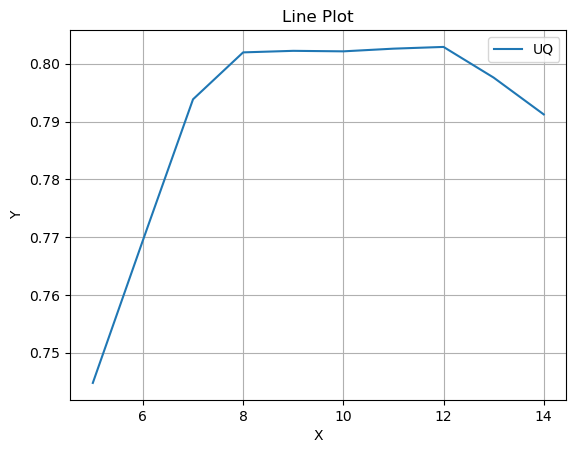

In [17]:
rho_list = np.asarray(rho_list)
rho = rho_list[:,0]
n_umlip = rho_list[:,1]
plt.plot(rho, n_umlip,label='UQ')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Line Plot')
plt.legend()
plt.grid(True)
plt.savefig('rho for various models.png')
plt.show()

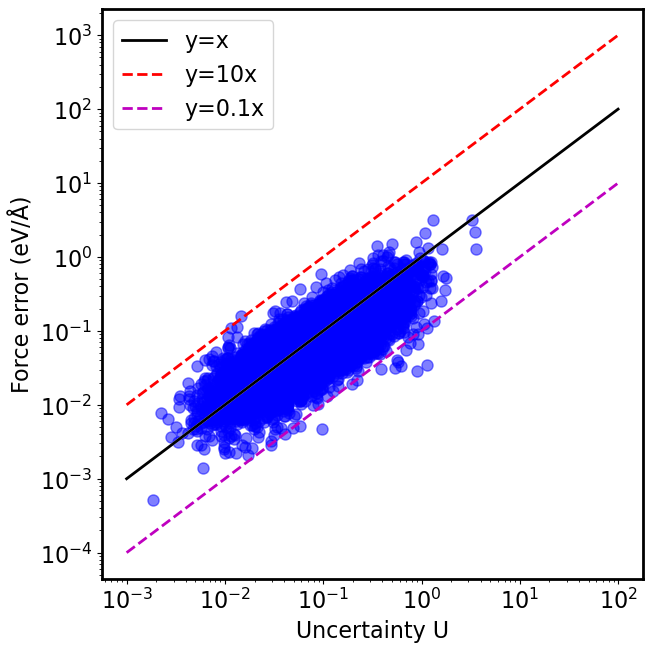

In [22]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.ticker import LogLocator, NullLocator
UQ = pd.read_pickle("./UQ11.pckl.gzip", compression="gzip")


plt.rcParams.update({
    'font.size': 16,  # Increase font size
    'axes.labelsize': 16,  # Larger axis labels
    'axes.titlesize': 16,  # Larger titles
    'legend.fontsize': 14,  # Larger legend
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'lines.linewidth': 2,  # Thicker lines
    'lines.markersize': 8,  # Larger markers
})

plt.figure(figsize=(6.41, 6.41), constrained_layout=True)
X = UQ["Force_error_max"]
Y = UQ["Uncertainty U"]


pe_style = [pe.Stroke(linewidth=2, foreground='white'), pe.Normal()]

plt.scatter(X, Y, c="blue", alpha = 0.5)
x_line = np.logspace(-3, 2, 100)  # From 0.001 to 100
plt.plot(x_line, x_line, 'k-', label='y=x',path_effects=pe_style)  # Y=X
plt.plot(x_line, 10*x_line, 'r--', label='y=10x')  # Y=10X
plt.plot(x_line, 0.1*x_line, 'm--', label='y=0.1x')  # Y=0.1X
ax = plt.gca()

ax.xaxis.set_minor_locator(NullLocator())  # 禁用 X 轴小刻度
ax.yaxis.set_minor_locator(NullLocator())  # 禁用 Y 轴小刻度
for spine in ax.spines.values():
    spine.set_linewidth(2)

# 添加标题和标签
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Uncertainty U', fontsize=16)
plt.ylabel('Force error (eV/Å)', fontsize=16)
plt.tick_params(axis='both', labelsize=16)
plt.legend(fontsize=16)
# plt.savefig('W_best_UQ_error.svg', format='svg', dpi=200)
plt.show()

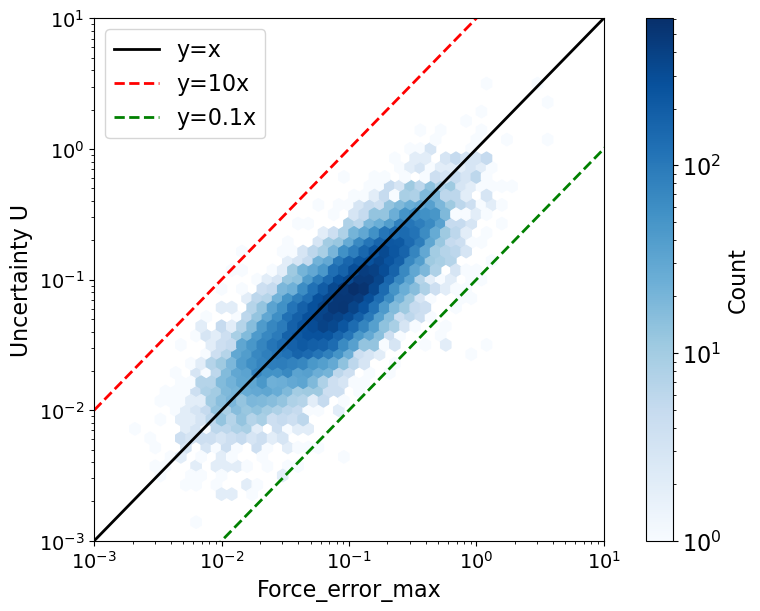

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
plt.figure(figsize=(7.5, 6), constrained_layout=True)
X = UQ["Force_error_max"]
Y = UQ["Uncertainty U"]

# 绘制六边形密度图
plt.hexbin(X, Y, gridsize=50, cmap='Blues', xscale='log', yscale='log',
                extent=[-3, 1, -3, 1], mincnt=1, norm=LogNorm(vmin=1))

# 添加 y=x, y=10x, y=0.1x 线
x_line = np.logspace(-3, 2, 100)  # From 0.001 to 100
plt.plot(x_line, x_line, 'k-', label='y=x')  # Y=X
plt.plot(x_line, 10*x_line, 'r--', label='y=10x')  # Y=10X
plt.plot(x_line, 0.1*x_line, 'g--', label='y=0.1x')  # Y=0.1X
plt.xlim(1e-3,1e1)
plt.ylim(1e-3,1e1)

# 添加颜色条
plt.colorbar(label='Count')

# 添加标题和标签
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Force error", fontsize=16)
plt.ylabel("Uncertainty U", fontsize=16)
plt.tick_params(axis='both', labelsize=14)
plt.legend(fontsize=16)

# 保存图像（可选）
# plt.savefig('E_UQ_F_UQ_hexbin.svg', format='svg', bbox_inches='tight')
plt.show()